# 📔 READ_ME und TO_DO

#### README

In [70]:
%%writefile '/content/drive/MyDrive/Colab Notebooks/SEO/READ_ME.md'
# 🚀 SEO Automation Pipeline mit OpenAI & Retrieval (RAG)

Dieses Projekt bietet eine **komplette End-to-End-Pipeline für die SEO-Optimierung von Websites**, inklusive **Web-Scraping, SEO-Analyse, KI-gestützter Text-Optimierung und Qualitätskontrolle**.

Kern des Projekts sind **automatisierte Abläufe**, die von der **Datengewinnung bis zur SEO-optimierten Textgenerierung** reichen.
Mithilfe von **OpenAI (ChatGPT)** und einer **Retrieval Augmented Generation (RAG)-Architektur** wird sichergestellt, dass die finalen Texte nicht nur **SEO-freundlich**, sondern auch **grammatikalisch korrekt und hochwertig** sind.

## 📚 Inhaltsverzeichnis

- Features
- Projektstruktur
- Ablauf & Module
- Technologien
- Installation
- Nutzung
- Ziele
- Roadmap

## ✅ Features

- 🌐 **Automatisiertes Web Scraping** (inkl. Filter für relevante Inhalte)
- ✍️ **Generierung von SEO-optimierten Texten** mithilfe der OpenAI API
- 🧠 **RAG-gestützte Fehlererkennung & Textkorrektur** mit Vektordatenbank (FAISS)
- 📊 **Analyse der Optimierungsergebnisse** (Statistiken, Ähnlichkeiten, Visualisierungen)
- 📈 **Keyword-Analyse und Keyword-Optimierung**
- 📦 Ausgabe in **HTML und PDF** für Kunden
- 📊 Umfangreiche **Datenvisualisierungen** (Wordclouds, Cosine Similarity, Keyword-Verteilung)

## 🗂️ Projektstruktur

```
SEO-Project/
├── data/                # Prompts, Fehler-Korrektur-Daten, weitere JSON Dateien
├── notebooks/           # Colab/Notebooks zum Starten und Entwickeln
├── src/                # Source Code (Python-Klassen und Module)
│   ├── webscraper.py    # Webscraping und Text-Extraktion
│   ├── llm_processor.py # Anbindung an OpenAI API, Keyword Extraktion
│   ├── chatbot.py       # Zentrale Chatbot-Klasse zur Kommunikation mit GPT
│   ├── seoanalyzer.py   # Analyse und Auswertung der Texte
│   ├── github.py        # Automatischer Upload ins GitHub Repo
│   ├── rag_checker.py   # RAG-Modul für Fehlerkorrektur via FAISS
│   ├── utils.py         # Hilfsmodule (z.B. für Prompt-Management)
│   └── embedding_demo.py# 3D Embedding- und Cosine Similarity Visualisierungen
└── requirements.txt    # Python-Abhängigkeiten
```

## ⚙️ Ablauf & Module

### 1. **Web Scraping**
- **src/webscraper.py**: Holt Inhalte von Webseiten, filtert irrelevante Seiten (z.B. Impressum, AGB).

### 2. **SEO-Optimierung mit OpenAI**
- **src/llm_processor.py**:
  - Extrahiert Keywords aus den Inhalten.
  - Optimiert die Texte für SEO mit gezielten Prompts.

### 3. **Fehlerkontrolle mit RAG**
- **src/rag_checker.py**: Erstellt eine Vektordatenbank mit bekannten Fehlern und Korrekturen. Erkennt fehlerhafte Formulierungen via Cosine Similarity und optimiert mit ChatGPT.

### 4. **Analyse & Visualisierung**
- **src/seoanalyzer.py**: Verarbeitet und analysiert die Original- und optimierten Texte.

### 5. **GitHub Automation**
- **src/github.py**: Lädt finale Ergebnisse in ein GitHub-Repo hoch.

## 🧰 Technologien

| Technologie                  | Beschreibung                                       |
|-----------------------------|---------------------------------------------------|
| Python                      | Hauptsprache                                       |
| OpenAI API (ChatGPT, GPT-4)  | Generative KI für SEO-Texte                       |
| FAISS                      | Vektorsuche für RAG und Text-Fehler                |
| Pandas, NumPy               | Datenanalyse und Verarbeitung                      |
| Matplotlib, Seaborn         | Visualisierungen                                   |
| Sentence Transformers       | Embedding-Erstellung für Vektordatenbank          |
| BeautifulSoup, Requests     | Webscraping                                        |
| Google Colab                | Entwicklung und Ausführung                        |

## 🚀 Installation

```bash
pip install -r requirements.txt
python -m spacy download de_core_news_sm
pip install faiss-cpu sentence-transformers openai wordcloud matplotlib seaborn
```

## 💻 Nutzung

```python
scraper = WebsiteScraper(start_url="https://www.example.com")
scraper.scrape_website()

llm_processor = LLMProcessor(PROJECT_ROOT, scraper.get_scraped_data())
llm_processor.run_all()

seo_checker = SEORAGChecker(quality_checker, chatbot_system_prompt)
final_text = seo_checker.check_text(optimized_text)

seo_analyzer = SEOAnalyzer(seo_json, original_texts, keywords_final)
seo_analyzer.run_analysis()
```

## 🎯 Ziele

- ✅ Vollständige Automatisierung der SEO-Optimierung
- ✅ RAG für sprachliche Qualitätskontrolle
- ✅ Kundenfertige PDF/HTML-Reports

## 🚧 Roadmap

- [ ] Automatische SEO Scores (z.B. Google Ads API)
- [ ] Automatische Keyword-Erweiterung
- [ ] Mehrsprachigkeit (aktuell Deutsch)
- [ ] WordPress-Integration

## 🤝 Zusammenarbeit

Contributions und Ideen willkommen!
👉 Pull-Request oder Issue eröffnen.


Overwriting /content/drive/MyDrive/Colab Notebooks/SEO/READ_ME.md


####TODO

In [71]:
%%writefile '/content/drive/MyDrive/Colab Notebooks/SEO/TO_DO.md'
# To-Do Liste: SEO Automation & KI-Projekt

Diese Liste fasst alle anstehenden Aufgaben im Projekt zusammen

---

## 1. **Allgemeine Projektorganisation**
- [ ] **Projektstruktur verbessern**: Ordner übersichtlich gestalten (z.B. `src/`, `data/`, `tests/`, `notebooks/`, dependencies.py).
- [ ] **Dokumentation erweitern**: READ_ME und Wiki (bzw. GitHub Pages) zu jedem Modul anlegen.
- [ ] **Automatisierte Tests** Pytest für Kernfunktionen einrichten.
- [ ] **Produkt für Kunden finalisieren**
- [ ] **FAISS DB**: automatisierte Erweiterung bei neu gefundenen Fehlern**
- [ ] **Template GitHub**: issues, pull-requests

---

## 2. **Vector-Datenbank (FAISS) & Retrieval**
- [ ] **VectorDB-Klasse finalisieren**:
  - [ ] Kleinere Bugs beheben
  - [ ] Userfreundliche Methoden für neue Einträge
- [ ] **Einrichtung der DB** bei Projektstart (Neubau vs. Laden) vereinheitlichen
- [ ] **Konfigurierbare Ähnlichkeits-Schwelle** (z.B. `threshold=0.6`) besser dokumentieren
- [ ] **Dynamische Filter** für bestimmte Fehlerkategorien (z.B. Stil vs. Grammatik) überlegen

---

## 3. **SEO-Optimierungs-Pipeline (LangChain)**
- [ ] **LangChain-Workflow** debuggen und lauffähig machen
  - [ ] Placeholder & Prompt-Mapping für `format_messages(...)` beheben
  - [ ] `.role` vs. `_role`-Konflikt lösen (Debug-Statements anpassen)
- [ ] **Prompts in JSON-Dateien** verlagern (z.B. `/data/prompts/`) und sauber verlinken
- [ ] **Google Ads Keywords** Integration:
  - [ ] Nur LLM-Keyword-Extraktion aufrufen, wenn keine Google-Keywords vorliegen
- [ ] **Supervisor-Feedback** integrieren (optional) & QA-Schritte definieren

---

## 4. **SEOGrammarChecker & PromptManager**
- [ ] Klassenrefactoring:
  - [ ] **`VectorDB`** vs. **`PromptManager`** vs. **`SEOGrammarChecker`** sauber trennen
  - [ ] Möglichst wenig Code-Duplikate, mehr modulare Testbarkeit
- [ ] **Konfigurationsdatei** (z.B. YAML) für Pfade, wie `FAISS_PATH` & Promptordner
- [ ] **Erweiterbare Prompt-Templates**:
  - [ ] Z.B. `seo_optimization.json`, `grammar_check.json`, `supervisor.json`, etc.

---

## 5. **Abschluss & Integration**
- [ ] **Dokumentation** aller Pipelines & Klassen in der README (oder in separater Doku)
- [ ] **
- [ ] **Optionale WordPress-Integration** in der Zukunft (Ideenspeicher)
  - [ ] Upload via REST API
  - [ ] Metadaten (Title, Slug, Tags etc.)


Overwriting /content/drive/MyDrive/Colab Notebooks/SEO/TO_DO.md


#🌋HYPERPARAMETER



In [72]:
### HYPERPARAMETER ###

from google.colab import drive, userdata
drive.mount('/content/drive', force_remount=True)

PROJECT_ROOT = userdata.get("gdrive_seo_root")
PROJECT_ROOT_ESC_STR = PROJECT_ROOT.replace('Colab Notebooks', 'Colab\ Notebooks')

SRC_PATH, DATA_PATH, TEST_PATH = PROJECT_ROOT + "/src", PROJECT_ROOT + "/data", PROJECT_ROOT + '/tests'
FAISS_PATH = DATA_PATH + '/faiss_db'
KEYWORD_PATH = DATA_PATH + '/keywords'
PROMPT_PATH = DATA_PATH + '/prompts'

START_URL = "https://www.rue-zahnspange.de/"
EXCLUDED_WEBSITES = ["impressum", "datenschutz", "agb"]


Mounted at /content/drive


# 🏁 Install requirements + dependencies

In [73]:
%run '/content/drive/MyDrive/Colab Notebooks/SEO/notebooks/Installation.ipynb'

In [74]:
%run '/content/drive/MyDrive/Colab Notebooks/SEO/src/dependencies.py'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 640x480 with 0 Axes>

# ⛩ push to github

In [75]:
import github
importlib.reload(github)
from github import GitHubManager

# Starte den GitHub-Sync
git_manager = GitHubManager(
    userdata.get("github_pat"),
    userdata.get("github_email"),
    userdata.get("github_username"),
    userdata.get("github_repo_seo"),
    PROJECT_ROOT_ESC_STR
)

git_manager.clone_repo()  # Klonen des Repos
git_manager.sync_project()

📥 Klonen des GitHub-Repositories...
📂 Kopiere das Projekt ins Repository...
🔧 Git-Konfiguration wird gesetzt...
➕ Änderungen hinzufügen...
📌 Änderungen committen...
⬆️ Änderungen werden auf GitHub gepusht...
✅ Repository erfolgreich synchronisiert!


# 🕸 scrap

In [76]:
import webscraper
importlib.reload(webscraper)
from webscraper import WebsiteScraper

scraper = WebsiteScraper(start_url=START_URL, max_pages=20, excluded_keywords=EXCLUDED_WEBSITES)

original_texts = scraper.get_filtered_texts()

# 📺 google ads seo keywords

In [77]:
import excelimporter
importlib.reload(excelimporter)
from excelimporter import ExcelImporter

importer = ExcelImporter(
    project_folder=PROJECT_ROOT,
    header=2
)
keyword_df = importer.import_all()

excluded_seo_keywords = ['spange de', 'kfo zentrum essen', 'gerade zahne', 'zahn spange']

keyword_df = keyword_df[(keyword_df['Avg. monthly searches'] > 10) &
 (~keyword_df['Keyword'].isin(excluded_seo_keywords))
 ].sort_values(by='Avg. monthly searches', ascending=False).reset_index(drop=True).copy()

google_ads_keywords = list(keyword_df['Keyword'])

✅ Geladen: /content/drive/MyDrive/Colab Notebooks/SEO/data/keywords/Keyword Stats 2025-03-09 at 12_41_38.xlsx


In [78]:
google_ads_keywords

['zahnärzte essen rüttenscheid',
 'zahnzusatzversicherung bei kindern',
 'retainer kosten',
 'retainer zähne',
 'kfo essen',
 'zahnspangen englisch',
 'reinigung zahnschienen',
 'zahnschienen reinigung',
 'kieferorthopädische zahnzusatzversicherung',
 'invisalign erfahrung',
 'kiefer fehlstellung',
 'zahn retainer']

# 🔮webtext analysis + SEO

In [79]:
import llmprocessor
importlib.reload(llmprocessor)
from llmprocessor import LLMProcessor

llm_processor = LLMProcessor(PROJECT_ROOT, original_texts, google_ads_keywords=google_ads_keywords)

optimized_texts = llm_processor.run_all()

✅ Google Ads Keywords werden verwendet. LLM Keyword Extraktion wird übersprungen.
📍 Stadt für SEO-Kontext wird via LLM ermittelt...
🚀 Starte SEO-Optimierung mit LLM...

=== SEO-Optimierung für https://www.rue-zahnspange.de/ ===
Analyse

Der bereitgestellte Text hat bereits eine solide Struktur, doch Verbesserungen in Bezug auf SEO sind notwendig. Die Verwendung von Keywords ist unzureichend und besteht nicht aus den vorgegebenen wichtigen SEO-Keywords. Der Text könnte von einer besseren Integration dieser Keywords in die Überschriften und Absätze profitieren, ohne dass der Lesefluss leidet. Auch die Fragen und Antworten im FAQ-Bereich könnten optimiert werden, um gezielte Suchanfragen abzudecken. Insgesamt fehlen spezifische Longtail-Keywords, die potenzielle Kunden ansprechen und die Sichtbarkeit der Website steigern könnten. Zudem ist der Text an einigen Stellen zu allgemein gehalten und könnte spezifischer auf die Region "Essen" und "Essen-Rüttenscheid" eingehen, um lokale Suchanfra

# 📁 Textprozessor

In [80]:
import textprocessor
importlib.reload(textprocessor)
from textprocessor import TextProcessor

# JSON mit den SEO-Abschnitten extrahieren
json_output = TextProcessor.extract_sections_to_json(list(optimized_texts.keys()), list(optimized_texts.values()))
seo_json = json.loads(json_output)

# texte bereinigen und hinzufügen
seo_json = TextProcessor.add_cleaned_text(seo_json, original_texts)

# Ergebnis anzeigen
print(json.dumps(seo_json, indent=4, ensure_ascii=False))


{
    "https://www.rue-zahnspange.de/": {
        "Analyse": "Der bereitgestellte Text hat bereits eine solide Struktur, doch Verbesserungen in Bezug auf SEO sind notwendig. Die Verwendung von Keywords ist unzureichend und besteht nicht aus den vorgegebenen wichtigen SEO-Keywords. Der Text könnte von einer besseren Integration dieser Keywords in die Überschriften und Absätze profitieren, ohne dass der Lesefluss leidet. Auch die Fragen und Antworten im FAQ-Bereich könnten optimiert werden, um gezielte Suchanfragen abzudecken. Insgesamt fehlen spezifische Longtail-Keywords, die potenzielle Kunden ansprechen und die Sichtbarkeit der Website steigern könnten. Zudem ist der Text an einigen Stellen zu allgemein gehalten und könnte spezifischer auf die Region Essen und Essen-Rüttenscheid eingehen, um lokale Suchanfragen zu bedienen.",
        "SEO": "RÜ Moderne Zahnspangen in Essen-Rüttenscheid für ein gesünderes Lächeln Entdecken Sie die Praxis RÜ Zahnspange in Essen-Rüttenscheid und unsere 

# 🔎 SEO Analyses + Statistics

In [81]:
llm_processor.get_keywords()['keywords_final']

['zahnärzte essen rüttenscheid',
 'zahnzusatzversicherung bei kindern',
 'retainer kosten',
 'retainer zähne',
 'kfo essen',
 'zahnspangen englisch',
 'reinigung zahnschienen',
 'zahnschienen reinigung',
 'kieferorthopädische zahnzusatzversicherung',
 'invisalign erfahrung',
 'kiefer fehlstellung',
 'zahn retainer']


🔍 Wortfrequenz-Vergleich:
🔹 Wortfrequenz-Differenzen für Text 1:
essen-rüttenscheid: 11
in: 10
oder: 3
zahnzusatzversicherung: 2
sind: 2
für: 2
kinder.: 2
einschließlich: 2
kosten: 1
behandlungen: 1
🔹 Wortfrequenz-Differenzen für Text 2:
in: 8
sie: 8
diese: 6
eine: 5
sind: 5
essen-rüttenscheid: 3
und: 3
zur: 3
von: 3
geräte: 2
🔹 Wortfrequenz-Differenzen für Text 3:
in: 5
essen-rüttenscheid: 2
wie: 2
essen-rüttenscheid,: 2
wir: 1
kindern: 1
einer: 1
behandlungsablauf: 1
beratungsgespräch: 1
durch: 1
🔹 Wortfrequenz-Differenzen für Text 4:
in: 5
und: 5
sie: 5
die: 5
für: 5
essen-rüttenscheid: 3
bei: 3
mit: 3
eine: 2
zahnschienen: 2
🔹 Wortfrequenz-Differenzen für Text 5:
zu: 6
der: 5
essen-rüttenscheid: 3
ist: 3
von: 3
die: 3
-: 3
wir: 2
kindern: 2
bietet: 2

🔍 Berechnung der Similarities:
📊 Durchschnittliche Similarities (Original -> Keywords): [0.00760909 0.00956733 0.0196589  0.10050857 0.0094858  0.0563428
 0.01694162 0.01694162 0.         0.04652006 0.02502024 0.01651267]
📊 Durchschn

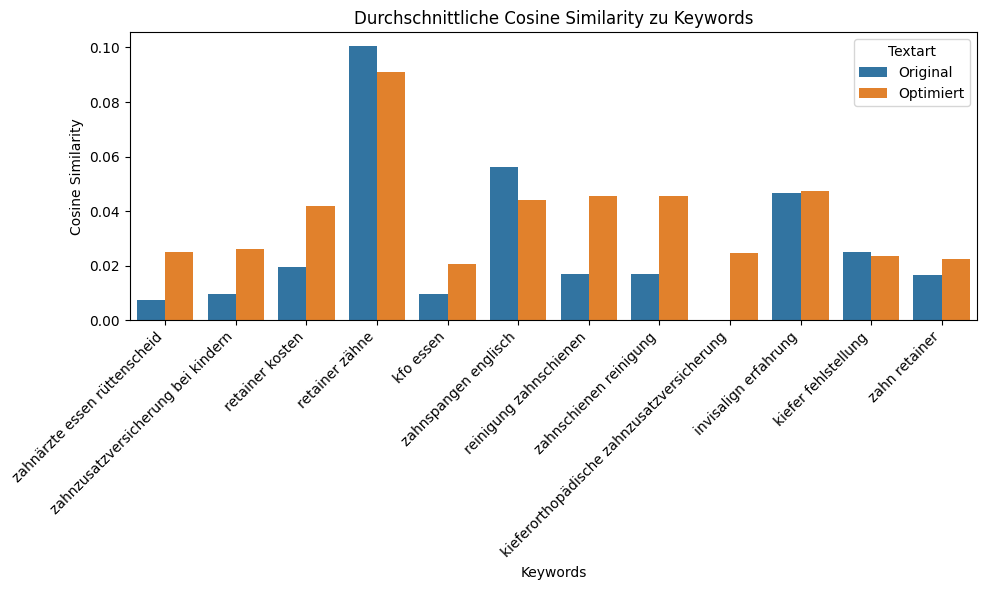


📊 Visualisierung der Keyword-Häufigkeiten:


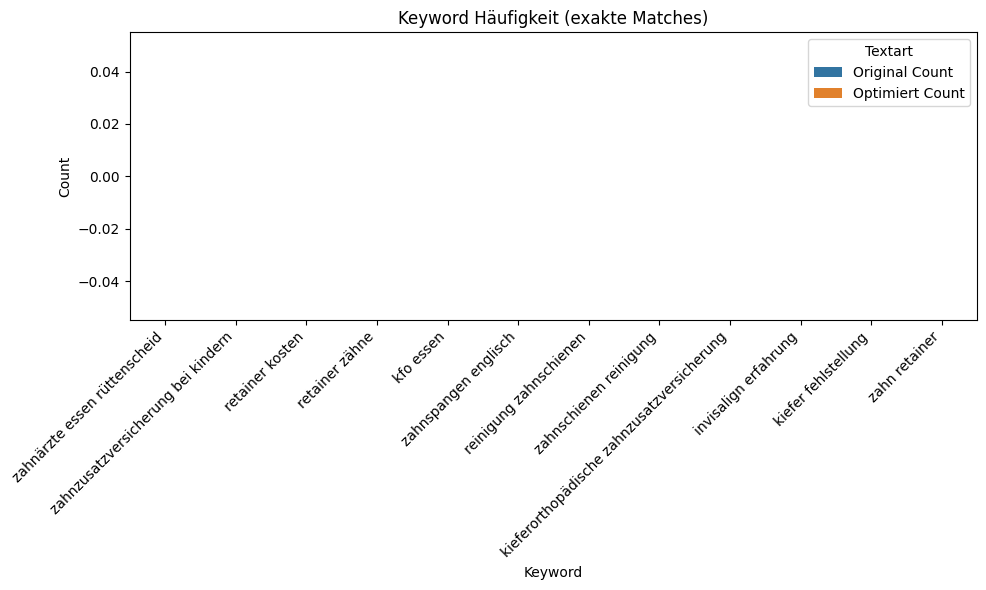


☁️ Wordcloud-Visualisierung:


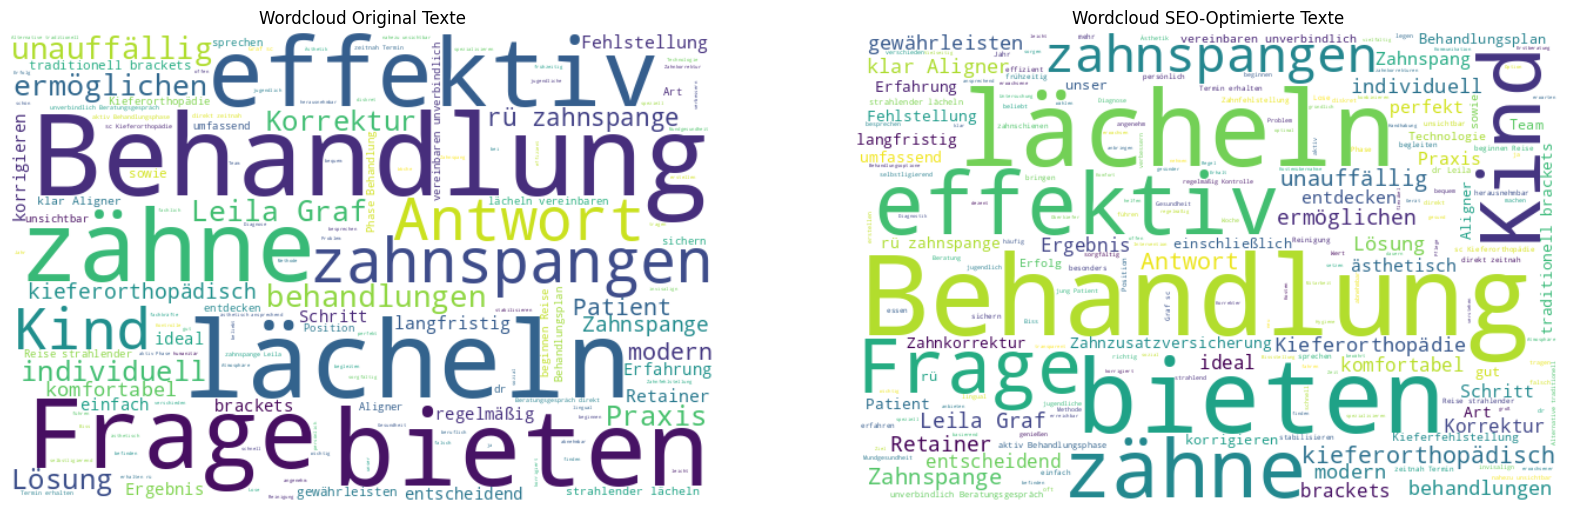

In [82]:
import seoanalyzer
importlib.reload(seoanalyzer)
from seoanalyzer import SEOAnalyzer

keywords_final = json.loads(llm_processor.get_keywords()['keywords_final']) if not google_ads_keywords else google_ads_keywords
seo_analyzer = SEOAnalyzer(seo_json, original_texts, keywords_final)
seo_analyzer.run_analysis()


# ▶◀ conversion rates, modelierungen

In [83]:
# Historische SEO-Daten
historical_data = {
    "Date": [
        "2023-01-01", "2023-02-01", "2023-03-01",
        "2023-04-01", "2023-05-01", "2023-06-01"
    ],
    "Organic_Sessions": [200, 220, 250, 400, 450, 480],
    "Conversion_Rate": [0.02, 0.021, 0.022, 0.028, 0.03, 0.031],
    "Average_Time_on_Page": [40, 42, 45, 60, 65, 70]
}


📊 Historische SEO-Trends


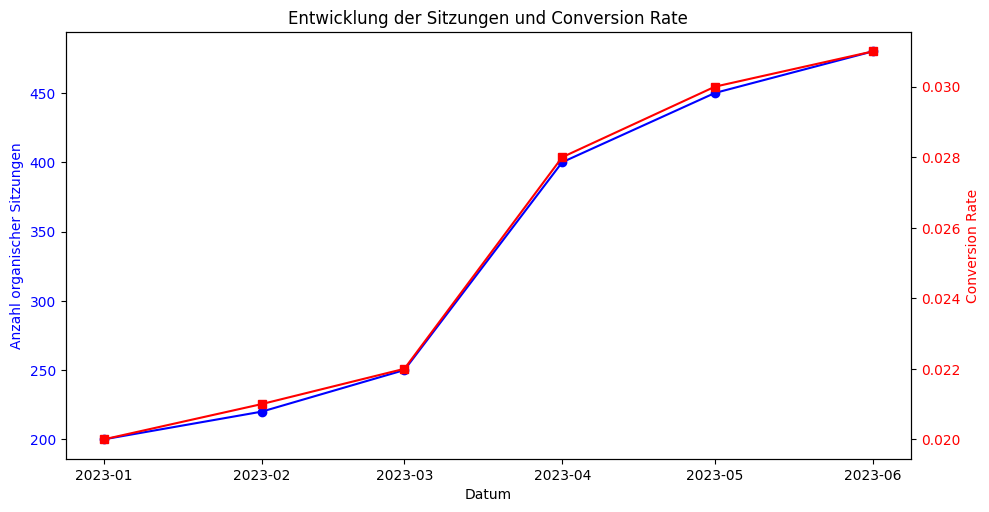

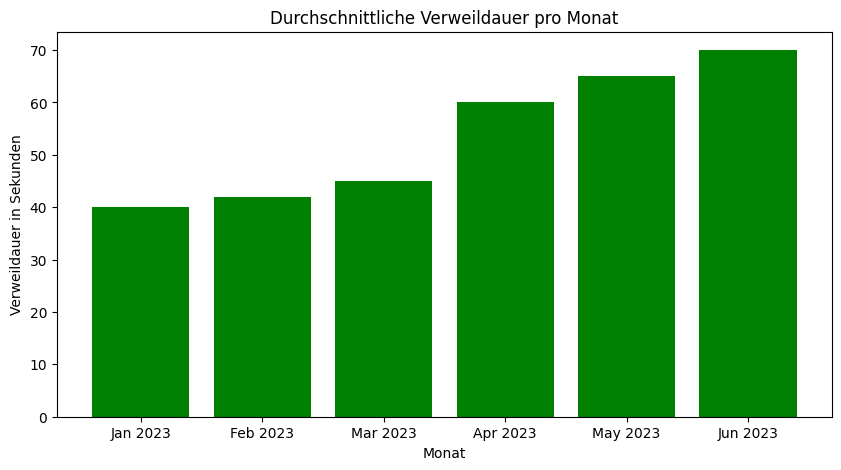


📈 Prognose der organischen Sitzungen


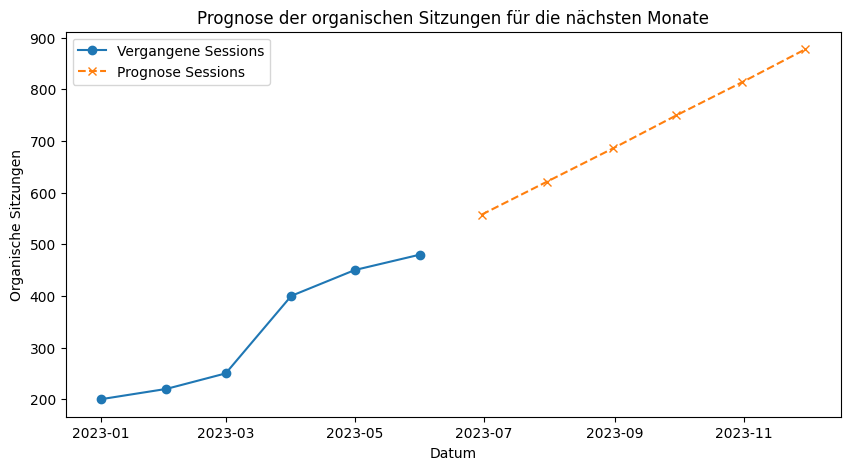


📈 Prognose der Conversion-Rate


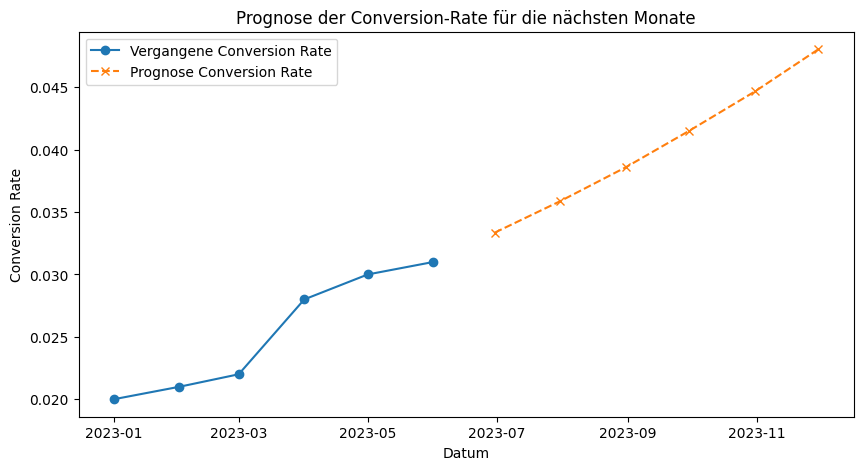

In [84]:
seo_analyzer = SEOAnalyzer(seo_json, original_texts, keywords_final, historical_data)
seo_analyzer.run_models()

# 🛏 embedding demo


📊 3D-Keyword Similarity


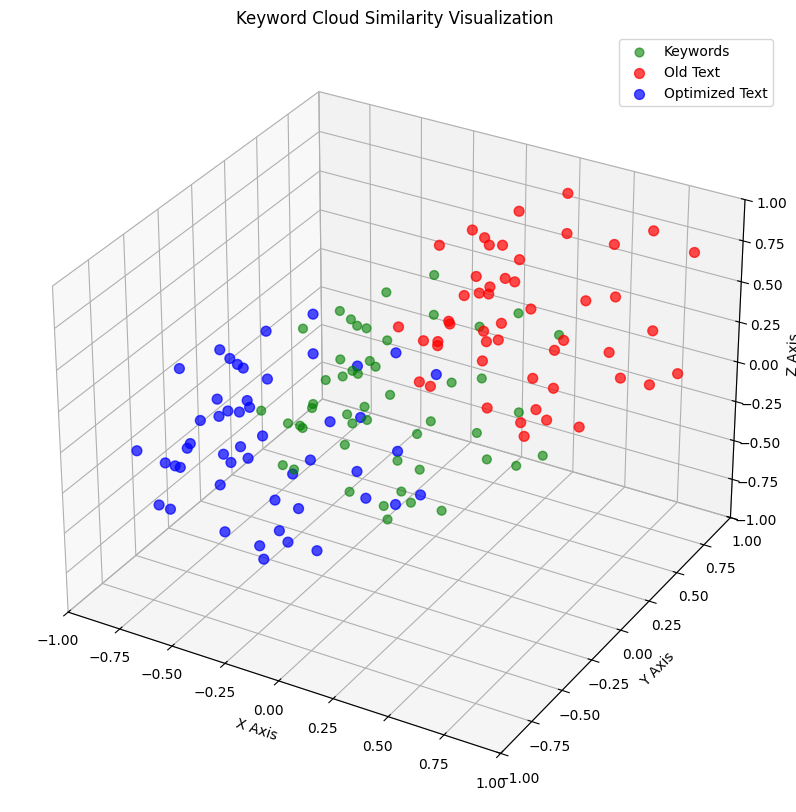


🔍 Cosine Similarity Steps


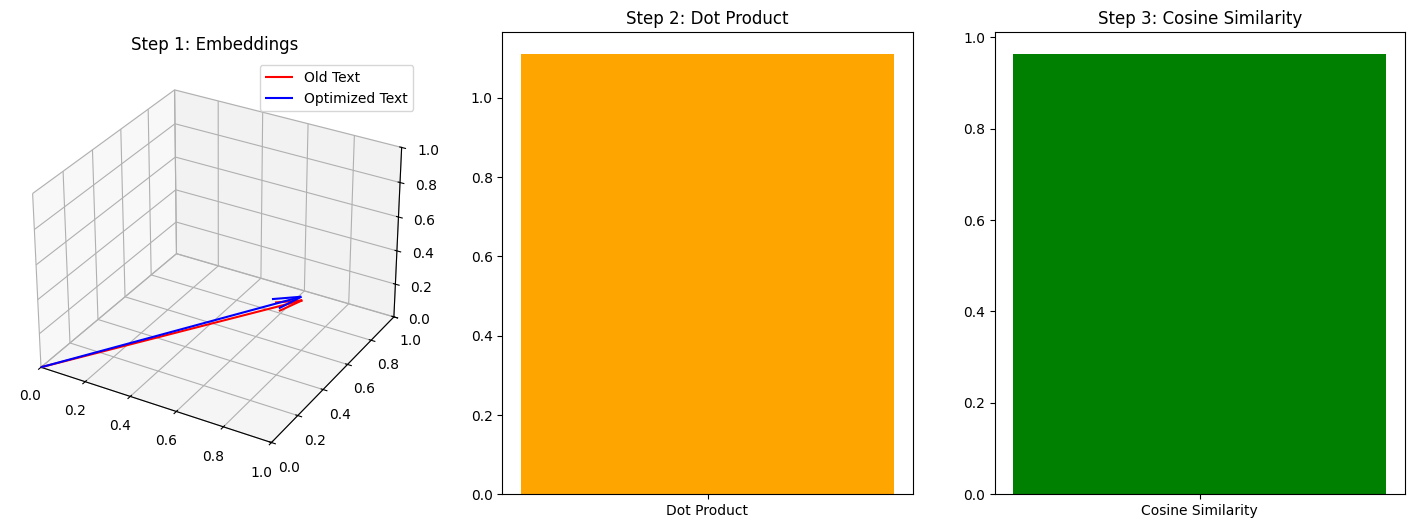


🔍 Cosine Comparision


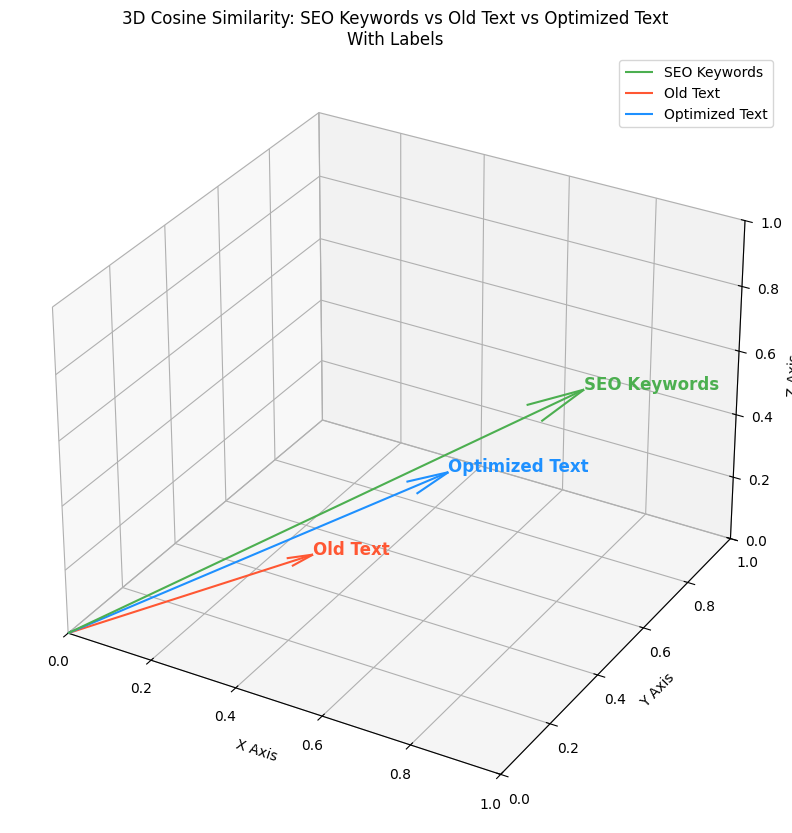


📌 3D BERT Embedding Visualization


In [85]:
import embeddingdemo
importlib.reload(embeddingdemo)
from embeddingdemo import EmbeddingDemo

demo = EmbeddingDemo()
demo.run_all_visualizations()

# ⛳ json to pdf + docx

In [86]:
%%capture
def json_to_html(json_data):
    # HTML-Template mit flexbox-basiertem Layout für "alt" und "SEO" nebeneinander
    html_template = """
    <!DOCTYPE html>
    <html lang="de">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Website Analyse</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 20px;
                line-height: 1.6;
            }
            h1 {
                text-align: center;
                color: #333;
            }
            .section {
                margin-bottom: 20px;
            }
            .url {
                font-size: 1.2em;
                font-weight: bold;
                color: #007BFF;
                margin-bottom: 10px;
            }
            /* Flexbox für zwei Spalten nebeneinander */
            .compare-row {
                display: flex;
                flex-direction: row;
                gap: 20px; /* Abstand zwischen den Spalten */
                margin-bottom: 20px;
            }
            .column {
                flex: 1;
                border: 1px solid #ccc;
                padding: 10px;
                box-sizing: border-box;
            }
            .header {
                font-size: 1.1em;
                font-weight: bold;
                color: #555;
                margin-bottom: 10px;
            }
            .content {
                white-space: normal;
            }
            /* Um Zeilenumbrüche aus dem JSON in <br> umzuwandeln */
            .page-break {
                page-break-after: always;
            }
        </style>
    </head>
    <body>
        <h1>Website Analyse & SEO</h1>
        {% for url, sections in data.items() %}
        <div class="section">
            <!-- Website-URL -->
            <p class="url">Website: {{ url }}</p>

            <!-- Beispiel: Andere Felder wie Analyse und Erklärung einfach "normal" untereinander -->
            <p class="header">Analyse</p>
            <p class="content">{{ sections.Analyse | replace('\\n','<br>') | safe }}</p>

            <p class="header">Erklärung</p>
            <p class="content">{{ sections.Erklärung | replace('\\n','<br>') | safe }}</p>

            <!-- Jetzt die beiden Felder "alt" und "SEO" nebeneinander -->
            <div class="compare-row">
                <!-- linke Spalte: alt -->
                <div class="column">
                    <p class="header">alt</p>
                    <p class="content">{{ sections.alt | replace('\\n','<br>') | safe }}</p>
                </div>
                <!-- rechte Spalte: SEO -->
                <div class="column">
                    <p class="header">SEO</p>
                    <p class="content">{{ sections.SEO | replace('\\n','<br>') | safe }}</p>
                </div>
            </div>
        </div>
        <div class="page-break"></div>
        {% endfor %}
    </body>
    </html>
    """
    # Jinja2-Template Rendering
    template = Template(html_template)
    html_output = template.render(data=json_data)
    return html_output


html_output = json_to_html(seo_json)

# Speichere das HTML (Beispiel)
gdrive_seo_folder = userdata.get('gdrive_seo_folder')
with open("/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html", "w", encoding="utf-8") as file:
    file.write(html_output)


In [87]:
import json
from jinja2 import Template

def json_to_html(json_data):
    # HTML-Template mit EINER Spalte für "SEO" (die "alt"-Spalte entfällt)
    html_template = """
    <!DOCTYPE html>
    <html lang="de">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Website Analyse</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 20px;
                line-height: 1.6;
            }
            h1 {
                text-align: center;
                color: #333;
            }
            .section {
                margin-bottom: 20px;
            }
            .url {
                font-size: 1.2em;
                font-weight: bold;
                color: #007BFF;
                margin-bottom: 10px;
            }
            .header {
                font-size: 1.1em;
                font-weight: bold;
                color: #555;
                margin-bottom: 10px;
            }
            .content {
                white-space: normal;
                margin-bottom: 20px;
            }
            .column {
                border: 1px solid #ccc;
                padding: 10px;
                box-sizing: border-box;
            }
            /* Zeilenumbrüche aus dem JSON in <br> wandeln */
            .page-break {
                page-break-after: always;
            }
        </style>
    </head>
    <body>
        <h1>Website Analyse & SEO</h1>

        {% for url, sections in data.items() %}
        <div class="section">
            <!-- Website-URL -->
            <p class="url">Website: {{ url }}</p>

            <!-- "Analyse" normal untereinander -->
            <p class="header">Analyse</p>
            <p class="content">
                {{ sections.Analyse | replace('\\n','<br>') | safe }}
            </p>

            <!-- "Erklärung" normal untereinander -->
            <p class="header">Erklärung</p>
            <p class="content">
                {{ sections.Erklärung | replace('\\n','<br>') | safe }}
            </p>

            <!-- NUR noch die "SEO"-Spalte -->
            <div class="column">
                <p class="header">SEO</p>
                <p class="content">
                    {{ sections.SEO | replace('\\n','<br>') | safe }}
                </p>
            </div>
        </div>
        <div class="page-break"></div>
        {% endfor %}
    </body>
    </html>
    """
    template = Template(html_template)
    return template.render(data=json_data)


html_output = json_to_html(seo_json)

# Speichere das HTML (Beispiel)
gdrive_seo_folder = userdata.get('gdrive_seo_folder')
with open("/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html", "w", encoding="utf-8") as file:
    file.write(html_output)


In [88]:
async def html_to_pdf_playwright(html_input, output_file):
    """
    Nutzt das Headless Chromium von Playwright, um die HTML-Datei zu rendern
    und anschließend als PDF zu speichern.
    """
    async with async_playwright() as p:
        browser = await p.chromium.launch()
        page = await browser.new_page()

        # Lokale Datei per file:// - Protokoll laden
        # oder du kannst stattdessen "page.set_content()" verwenden
        url = "file://" + html_input  # z.B. "file:///content/drive/MyDrive/.../preview.html"
        await page.goto(url, wait_until="load")

        # PDF erzeugen (A4, Ränder anpassen etc.)
        await page.pdf(
            path=output_file,
            format="A4",
            margin={"top": "1cm", "right": "1cm", "bottom": "1cm", "left": "1cm"}
        )

        await browser.close()

# Aufruf in Colab:
html_input = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html"
output_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/output.pdf"

# Instead of using asyncio.run(), use the following inside a notebook cell:
import nest_asyncio
nest_asyncio.apply() # This line applies a patch to allow nested event loops.
asyncio.run(html_to_pdf_playwright(html_input, output_file))
print("PDF mit Playwright erstellt.")

PDF mit Playwright erstellt.


In [89]:
input_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html"
output_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/output.docx"

pypandoc.convert_file(
    source_file=input_file,
    to="docx",
    outputfile=output_file,
    extra_args=["--standalone"]
)
print("Konvertierung nach DOCX abgeschlossen.")


Konvertierung nach DOCX abgeschlossen.


# 📥 Tests

#### 📃 Doku

In [90]:
%%writefile '/content/drive/MyDrive/Colab Notebooks/SEO/tests/DOKU_TESTS.md'
# ✅ Pytest Template: Chatbot Klasse

## 1. Klassen & Methoden die getestet werden sollen

- **Chatbot**
  - `chat()`
  - `chat_with_streaming()`

---

## 2. Beispielhafte Inputs + erwartete Outputs pro Methode

| Methode                      | Beispiel Input                                                           | Erwartete Ausgabe    |
|-----------------------------|-------------------------------------------------------------------------|----------------------|
| `Chatbot.chat()`             | 'Das ist ein Test. Schreibe als Antwort "Test erfolgreich".'           | "Test erfolgreich"   |
| `Chatbot.chat_with_streaming()` | 'Das ist ein Test. Schreibe als Antwort "Test erfolgreich".'         | "Test erfolgreich"   |

---

## 3. Return-Typen der Methoden

| Methode                      | Rückgabe-Typ |
|-----------------------------|--------------|
| `Chatbot.chat()`             | `str`        |
| `Chatbot.chat_with_streaming()` | `str`     |

---

## 4. Externe Services mocken?

| Service         |  Mocken?                           |
|-----------------|-------------------------------------|
| OpenAI API      |  Nein                                |
| FAISS Index     |  Ja (kleine Test-Datenbank für FAISS) |

---

## 5. Ordnerstruktur für Tests

```bash
/project-root/
    /src/
        chatbot.py
    /tests/
        test_chatbot.py
    /logs/
        test_report.log
    ...
```

---


Overwriting /content/drive/MyDrive/Colab Notebooks/SEO/tests/DOKU_TESTS.md


#### 👷 code

In [91]:
pytest.main(['-v', TEST_PATH+'/chatbot_test/chatbot_test.py'])

======================================= test session starts ========================================
platform linux -- Python 3.11.11, pytest-8.3.5, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content
plugins: typeguard-4.4.2, anyio-3.7.1
collecting ... collected 2 items

drive/MyDrive/Colab Notebooks/SEO/tests/chatbot_test/chatbot_test.py::test_chat_method PASSED [ 50%]
drive/MyDrive/Colab Notebooks/SEO/tests/chatbot_test/chatbot_test.py::test_chat_with_streaming_method PASSED [100%]

========================================= warnings summary =========================================
../usr/local/lib/python3.11/dist-packages/_pytest/config/__init__.py:1277
  /usr/local/lib/python3.11/dist-packages/_pytest/config/__init__.py:1277: PytestAssertRewriteWarning:
  
  Module already imported so cannot be rewritten: anyio

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
=================================== 2 passed, 1 warning in 1.04s ===========

<ExitCode.OK: 0>

# 🎨 WIP RAG

In [92]:
chatbot_system_prompt = (
    "Du bist ein hochqualifizierter Korrekturleser und optimierst Texte für SEO-Zwecke. "
    "Du bist Teil eines RAG Systems und deine Aufgabe ist es, grammatikalische Fehler zu erkennen. Du bist die finale Korrektur für die Texte."
    "Du wirst context retrieval zu den Texten erhalten. Du wirst die Texte nur korrigieren, wenn grammatikalische Fehler auftreten"
    " oder wenn es grobe Fehler in der Formulierung gibt. Denke daran, dass die Texte bereits optimiert sind und nur die "
    "letzten Fehler erkannt werden müssen! Deswegen wirst du die Texte nur verändern, wenn du grammatikalische Fehler findest."
    "Wenn du Fehler findest, gebe den Text korrigiert zurück."
    "Wenn du keinen Fehler findest, gebe einfach nur den Text zurück."
    "Hier ist der context retrieval:"
)

chatbot_user_prompt = (
    "Bitte verbessere den folgenden Text:"
)

In [93]:
import rag
importlib.reload(rag)
from rag import RAG


# 1. RAG-Objekt anlegen
rag = RAG(FAISS_PATH, chatbot_system_prompt=chatbot_system_prompt,chatbot_user_prompt=chatbot_user_prompt)

# 2. Nur beim ersten Mal:
error_corrections = {
    "Eine Zahnspange kann Kiefergelenksbeschwerden, Kauen- und Sprechprobleme effektiv behandeln.":
    "Eine Zahnspange kann Kiefergelenksbeschwerden, sowie Kau- und Sprechprobleme effektiv behandeln.",
    "Als in Kenia geborene Kieferorthopädin bringt Dr. Meier eine multikulturelle Perspektive mit und spricht neben Deutsch auch Englisch, Swahili sowie über Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch.":
    "Als in Kenia geborene Kieferorthopädin bringt Dr. Meier eine multikulturelle Perspektive mit und spricht neben Deutsch auch Englisch und Swahili. Dazu hat sie Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch.",
    "Sie hat ihren Master of Science in Geochemie von der Universität Münster, Deutschland, und hat an der Universität Düsseldorf abgeschlossen.":
    "Sie hat ihren Master of Science in Geochemie von der Universität Münster, Deutschland, und hat an der Universität Düsseldorf promoviert.",
    "Ihre Qualifikationen umfassen nicht nur Fachwissen, sondern auch eine besondere Hingabe zu einem ästhetischen Lächeln.":
    "Sie ist hoch qualifiziert und hat eine besondere Hingabe zu einem ästhetischen Lächeln. ",
    "behandlungsorientierte Zahnberatung": "patientenorientierte Beratung",
    "ästehthetisches Lächeln": "ästhetisches Lächeln",
    "Nachdem Ihr Behandlungsplan von der Krankenkasse genehmigt wurde": "Nachdem Ihr Behandlungsplan von der Krankenkasse bestätigt wurde",
    "Der aktuelle Text zur Zahnspangenpraxis": "Der aktuelle Text zur kieferorthopädischen Praxis"
}
rag.initialize_db(error_corrections=error_corrections)

# 3. Weitere Einträge
# new_entries = {
#     "Unsere Firma hat viele zufriedene Kunde": "Unsere Firma hat viele zufriedene Kunden"
# }
# rag.add_entries(new_entries)

# 4. Text prüfen
seo_text = seo_json['https://www.rue-zahnspange.de/']['SEO']
improved = rag.check_text(seo_text)
print("Verbesserter Text:\n", improved)


✅ Ein vorhandener FAISS-Index wurde gefunden. Lade Index...
🔎 Lade vorhandenen FAISS-Index...
✅ Index und Fehler-Korrekturen aus '/content/drive/MyDrive/Colab Notebooks/SEO/data/faiss_db' geladen.
RÜ Moderne Zahnspangen in Essen-Rüttenscheid für ein gesünderes Lächeln Entdecken Sie die Praxis RÜ Zahnspange in Essen-Rüttenscheid und unsere vielseitigen kieferorthopädischen Behandlungen für Kinder und Jugendliche, die ein langanhaltendes und gesundes Lächeln ermöglichen. Öffnungszeiten Hier finden Sie uns in Essen-Rüttenscheid Anbindungen Vor unserer Tür befindet sich die Haltestelle Martinstraße, erreichbar über: Bahn: 107, 108, U11 Bus: 142, 160, 161 Direkt gegenüber der Praxis in Essen-Rüttenscheid befindet sich ein geräumiger Parkplatz. Behandlungen für Ihr perfektes Lächeln in Essen-Rüttenscheid Unser Ziel ist es, Ihnen nicht nur ein ästhetisch ansprechendes Lächeln zu schenken, sondern auch Ihre gesamte Kiefergesundheit zu verbessern. Wir begleiten Sie auf jedem Schritt dieses Wege

In [94]:
import os
import json
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from chatbot import Chatbot

# -------------------------
# 1) VectorDB
# -------------------------

class VectorDB:
    """
    Eine Klasse für alles rund um deine Vektordatenbank:
    - Aufbauen & Laden (FAISS)
    - Neue Einträge hinzufügen
    - Querying für Context Retrieval
    """

    def __init__(self, db_folder):
        """
        :param db_folder: Pfad zu deinem Datenbank-Ordner, z.B. "/content/drive/MyDrive/SEO/data"
        """
        self.db_folder = db_folder
        self.index_file = os.path.join(db_folder, "faiss_index.bin")
        self.json_file  = os.path.join(db_folder, "faiss_index.json")

        self.index = None
        self.error_dict = {}  # z.B. {fehler: korrektur}

        self.model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

    def build_index(self, error_corrections: dict):
        """
        Baut einen neuen FAISS-Index aus den übergebenen Fehler-Korrektur-Paaren.
        """
        print("🔨 Baue neuen FAISS-Index...")
        os.makedirs(self.db_folder, exist_ok=True)

        self.error_dict = error_corrections
        errors = list(self.error_dict.keys())

        # Embeddings
        embeddings = np.array([self.model.encode(e) for e in errors], dtype="float32")

        # FAISS-Index anlegen
        self.index = faiss.IndexFlatL2(embeddings.shape[1])
        self.index.add(embeddings)

        # Daten auf Festplatte schreiben
        faiss.write_index(self.index, self.index_file)
        with open(self.json_file, "w", encoding="utf-8") as f:
            json.dump(self.error_dict, f, ensure_ascii=False)

        print(f"✅ Neuer Index + JSON in '{self.db_folder}' erstellt.")

    def load_index(self):
        """
        Lädt einen bereits existierenden FAISS-Index und die Fehler-Daten.
        """
        if not (os.path.exists(self.index_file) and os.path.exists(self.json_file)):
            raise FileNotFoundError("❌ Kein FAISS-Index gefunden. Bitte build_index() aufrufen.")

        print("🔎 Lade vorhandenen FAISS-Index...")
        self.index = faiss.read_index(self.index_file)

        with open(self.json_file, "r", encoding="utf-8") as f:
            self.error_dict = json.load(f)

        print("✅ Index & Fehler-Korrekturen geladen.")

    def add_entries(self, new_error_corrections: dict):
        """
        Fügt weitere Fehler-Korrektur-Paare hinzu, ohne alles neu zu bauen.
        """
        if self.index is None:
            # Versuch zu laden, falls vorhanden
            if os.path.exists(self.index_file) and os.path.exists(self.json_file):
                self.load_index()
            else:
                raise FileNotFoundError("❌ Kein Index vorhanden. Bitte erst build_index() nutzen.")

        # Merge in self.error_dict
        for fehler, korrektur in new_error_corrections.items():
            self.error_dict[fehler] = korrektur

        # embeddings nur für die neuen keys
        new_keys = list(new_error_corrections.keys())
        new_embeds = np.array([self.model.encode(k) for k in new_keys], dtype="float32")

        # An Index anhängen
        self.index.add(new_embeds)

        # Speichern
        faiss.write_index(self.index, self.index_file)
        with open(self.json_file, "w", encoding="utf-8") as f:
            json.dump(self.error_dict, f, ensure_ascii=False)

        print(f"✅ {len(new_keys)} neue Einträge hinzugefügt und Index aktualisiert.")

    def query(self, text: str, top_k=3, threshold=0.6):
        """
        Sucht in der DB nach ähnlichen fehlerhaften Formulierungen.

        :param text: Der zu prüfende Satz/Abschnitt
        :param top_k: Anzahl der gesuchten Ähnlichkeiten
        :param threshold: Distanzschwelle
        :return: Liste [(fehler, korrektur), ...]
        """
        if self.index is None:
            self.load_index()

        embed = np.array([self.model.encode(text)], dtype="float32")
        distances, indices = self.index.search(embed, top_k)

        all_errors = list(self.error_dict.keys())

        results = []
        for i in range(top_k):
            if distances[0][i] < threshold:
                fehler_key = all_errors[indices[0][i]]
                korrektur = self.error_dict[fehler_key]
                results.append((fehler_key, korrektur))
        return results

    def retrieve_context(self, seo_text: str) -> str:
        """
        Durchsucht den seo_text Satz für Satz, holt ggf. Korrekturvorschläge
        und baut einen Kontextstring.
        """
        lines = []
        for s in seo_text.split(". "):
            suggestions = self.query(s)
            for old, new in suggestions:
                lines.append(f"- Fehler: {old} ➝ Verbesserung: {new}")

        if lines:
            return "Bekannte Fehler/Korrekturen:\n" + "\n".join(lines)
        else:
            return "Keine bekannten Fehler gefunden."



In [95]:
import os
import json
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from chatbot import Chatbot
# -------------------------
# 2) PromptManager
# -------------------------

class PromptManager:
    """
    Lädt Prompts aus dem /data/prompts Ordner und kombiniert sie mit
    dem Context aus der VectorDB, um einen finalen Prompt zu erstellen.
    """

    def __init__(self, prompts_folder="./data/prompts"):
        """
        :param prompts_folder: Ordner, in dem .json (oder .txt) Prompts liegen
        """
        self.prompts_folder = prompts_folder
        # Du könntest hier diverse Prompts laden oder
        # sie dynamisch in build_final_prompt() nach Dateiname laden

    def load_prompt(self, filename: str) -> dict:
        """
        Lädt einen JSON-Prompt aus dem Ordner, z.B. 'grammar_prompt.json'.
        """
        path = os.path.join(self.prompts_folder, filename)
        try:
            with open(path, "r", encoding="utf-8") as f:
                return json.load(f)
        except FileNotFoundError:
            print(f"⚠️ Prompt-Datei {path} nicht gefunden!")
            return {}
        except json.JSONDecodeError:
            print(f"⚠️ Ungültiges JSON in {path}")
            return {}

    def build_final_prompt(self, base_prompt_file: str, context: str, user_text: str) -> (str, str):
        """
        Kombiniert:
         - base_prompt_file (System-/User-Prompts)
         - den 'context' aus der VectorDB
         - den 'user_text' (SEO-Text)
        und gibt final (system_prompt, user_prompt) zurück.
        """
        prompt_data = self.load_prompt(base_prompt_file)

        # Annahme: JSON enthält z.B. { "system_prompt": "...", "user_prompt": "..." }
        system_prompt = prompt_data.get("system_prompt", "")
        user_prompt   = prompt_data.get("user_prompt", "")

        # Kontext an system_prompt anhängen
        system_prompt_full = f"{system_prompt}\n{context}"

        # SEO-Text an user_prompt anhängen
        user_prompt_full = f"{user_prompt}\n\n{user_text}"

        return (system_prompt_full, user_prompt_full)




In [96]:
import os
import json
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from chatbot import Chatbot
# -------------------------
# 3) SEOGrammarChecker
# -------------------------

class SEOGrammarChecker:
    """
    Nutzt VectorDB, um Kontext zu holen,
    PromptManager, um finalen Prompt zu bauen,
    und Chatbot, um den Text zu optimieren.
    """

    def __init__(self, vector_db: VectorDB, prompt_manager: PromptManager):
        """
        :param vector_db: Instanz von VectorDB
        :param prompt_manager: Instanz von PromptManager
        """
        self.vector_db = vector_db
        self.prompt_manager = prompt_manager

    def check_text(self, seo_text: str, prompt_file: str = "grammar_prompt.json") -> str:
        """
        1) Hole Context aus VectorDB
        2) Lade base_prompt aus 'prompt_file'
        3) Baue finalen Prompt
        4) Chatbot-Aufruf
        :return: Grammatikalisch verbesserter Text
        """
        # 1) Kontext für den Text
        context_str = self.vector_db.retrieve_context(seo_text)

        # 2) Prompts aus JSON
        # z.B. { "system_prompt": "Du bist ein Korrektor...", "user_prompt": "Bitte verbessere..." }
        (system_prompt, user_prompt) = self.prompt_manager.build_final_prompt(
            base_prompt_file=prompt_file,
            context=context_str,
            user_text=seo_text
        )

        # 3) Chatbot-Aufruf
        cb = Chatbot(systemprompt=system_prompt, userprompt=user_prompt)
        final_text = cb.chat()
        return final_text


# ⛓ WIP Langchain

In [97]:
import subprocess
from langchain_openai import ChatOpenAI
from google.colab import userdata
import os

subprocess.run(["pip", "install", "--upgrade", "pydantic"])

os.environ['OPENAI_API_KEY'] = userdata.get('open_ai_api_key')

llm = ChatOpenAI(temperature=0,
    model = "gpt-4o-mini-2024-07-18",
    openai_api_key=os.environ['OPENAI_API_KEY'],
)

In [98]:
from typing_extensions import assert_type
from utils import load_prompts

prompts = load_prompts(PROMPT_PATH + '/optimize_seo.json')


system_prompt = prompts["system_prompt"]
user_prompt = prompts["user_prompt"]

test_prompt = f"""{prompts["user_prompt"]}"""
#test_prompt = test_prompt.replace('{keywords}', google_ads_keywords.__str__())

user_prompt = user_prompt.replace('{keywords}', google_ads_keywords.__str__())
user_prompt = user_prompt.replace('{original_text}', seo_json['https://www.rue-zahnspange.de/']['SEO'])


print(test_prompt)

Optimiere den folgenden Text für SEO, indem du die Keywords sinnvoll integrierst:

Keywords: {keywords}

Text:
{original_text}

Achte auf natürliche Sprache, gute Lesbarkeit und Vermeide Keyword-Stuffing.
Gib den optimierten Text zurück.


In [99]:
google_ads_keywords

['zahnärzte essen rüttenscheid',
 'zahnzusatzversicherung bei kindern',
 'retainer kosten',
 'retainer zähne',
 'kfo essen',
 'zahnspangen englisch',
 'reinigung zahnschienen',
 'zahnschienen reinigung',
 'kieferorthopädische zahnzusatzversicherung',
 'invisalign erfahrung',
 'kiefer fehlstellung',
 'zahn retainer']

In [100]:
', '.join(google_ads_keywords)

'zahnärzte essen rüttenscheid, zahnzusatzversicherung bei kindern, retainer kosten, retainer zähne, kfo essen, zahnspangen englisch, reinigung zahnschienen, zahnschienen reinigung, kieferorthopädische zahnzusatzversicherung, invisalign erfahrung, kiefer fehlstellung, zahn retainer'

In [101]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import (AIMessage, HumanMessage, SystemMessage)

def extract_keywords(text):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="Du bist ein SEO-Experte, spezialisiert auf Keyword-Recherche."),
        HumanMessage(content=f"""
        Analysiere den folgenden Unternehmens-Text und finde die besten SEO-Keywords.
        Berücksichtige lokale Infos, falls vorhanden.

        Text:
        {text}

        Gib mir eine Liste von Keywords.
        """)
    ])
    # format_messages converts the messages to a list of dictionaries
    messages = prompt.format_messages(text=text)
    response = llm(messages)
    return response.content

In [102]:
def optimize_text_for_seo(text, keywords):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="Du bist ein professioneller SEO-Texter."),
        HumanMessage(content=f"""
        Optimiere den folgenden Text für SEO, indem du diese Keywords sinnvoll integrierst:

        Keywords: {keywords}

        Achte auf natürliche Sprache, gute Lesbarkeit und Vermeidung von Keyword-Stuffing.

        Text:
        {text}

        Gib mir den optimierten Text zurück.
        """)
    ])
    # format_messages converts the messages to a list of dictionaries
    messages = prompt.format_messages(text=text, keywords=keywords)  # Pass keywords here
    response = llm(messages)
    return response.content


In [103]:
def grammar_and_style_check(text):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="Du bist ein erfahrener Lektor und Sprachexperte."),
        HumanMessage(content=f"""
        Prüfe den folgenden Text auf Grammatik, Rechtschreibung und Stil.
        Mache den Text flüssig, professionell und fehlerfrei.

        Text:
        {text}

        Gib den verbesserten Text zurück.
        """)
    ])
    # format_messages converts the messages to a list of dictionaries
    messages = prompt.format_messages(text=text)  # Format with text
    response = llm(messages)
    return response.content

In [104]:
def supervisor_check(original_text, keywords, optimized_text, final_text):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="Du bist ein Supervisor, der SEO- und Textqualität überprüft."),
        HumanMessage(content=f"""
        Hier sind die Arbeitsschritte:

        Ursprünglicher Text:
        {original_text}

        Gefundene Keywords:
        {keywords}

        SEO-optimierter Text:
        {optimized_text}

        Finaler Text (nach Lektorat):
        {final_text}

        Beantworte:
        1. Sind alle wichtigen Keywords sinnvoll eingebaut?
        2. Ist der Text professionell und lesbar?
        3. Verbesserungsvorschläge?
        Wenn alles gut ist, antworte: 'Finaler Text akzeptiert.'
        """)
    ])
    # format_messages converts the messages to a list of dictionaries
    messages = prompt.format_messages(
        original_text=original_text,
        keywords=keywords,
        optimized_text=optimized_text,
        final_text=final_text
    )  # Format with all variables
    response = llm(messages)
    return response.content

In [105]:
def seo_pipeline(original_text):
    # Schritt 1: Keywords finden
    print("Schritt 1: Keywords finden...")
    keywords = extract_keywords(original_text)
    print("Gefundene Keywords:", keywords)

    # Schritt 2: SEO-Optimierung
    print("\nSchritt 2: SEO-Optimierung...")
    optimized_text = optimize_text_for_seo(original_text, keywords)
    print("SEO-optimierter Text:\n", optimized_text)

    # Schritt 3: Grammatikprüfung
    print("\nSchritt 3: Grammatikprüfung...")
    final_text = grammar_and_style_check(optimized_text)
    print("Finaler Text nach Lektorat:\n", final_text)

    # Optional: Supervisor
    print("\nSupervisor prüft...")
    supervisor_feedback = supervisor_check(original_text, keywords, optimized_text, final_text)
    print("Supervisor Feedback:\n", supervisor_feedback)

    return final_text


In [106]:
seo_json['https://www.rue-zahnspange.de/']['SEO']

'RÜ Moderne Zahnspangen in Essen-Rüttenscheid für ein gesünderes Lächeln Entdecken Sie die Praxis RÜ Zahnspange in Essen-Rüttenscheid und unsere vielseitigen kieferorthopädischen Behandlungen für Kinder und Jugendliche, die ein langanhaltendes und gesundes Lächeln ermöglichen. Öffnungszeiten Hier finden Sie uns in Essen-Rüttenscheid Anbindungen Vor unserer Tür befindet sich die Haltestelle Martinstraße, erreichbar über: Bahn: 107, 108, U11 Bus: 142, 160, 161 Direkt gegenüber der Praxis in Essen-Rüttenscheid befindet sich ein geräumiger Parkplatz. Behandlungen für Ihr perfektes Lächeln in Essen-Rüttenscheid Unser Ziel ist es, Ihnen nicht nur ein ästhetisch ansprechendes Lächeln zu schenken, sondern auch Ihre gesamte Kiefergesundheit zu verbessern. Wir begleiten Sie auf jedem Schritt dieses Weges mit Professionalität und Sorgfalt. Transparente Aufklärung über unsere kieferorthopädischen Behandlungen Wir setzen auf offene Kommunikation und ausführliche Beratung, damit Sie jeden Schritt Ih

In [107]:
if __name__ == "__main__":
    unternehmens_text = seo_json['https://www.rue-zahnspange.de/']['SEO']

    final_output = seo_pipeline(unternehmens_text)
    print("\n--- Finaler SEO-optimierter Text ---\n")
    print(final_output)

Schritt 1: Keywords finden...
Gefundene Keywords: Hier ist eine Liste von potenziellen SEO-Keywords, die auf dem Unternehmens-Text basieren. Diese Keywords berücksichtigen sowohl die Dienstleistungen als auch die lokale Ausrichtung auf Essen-Rüttenscheid:

### Lokale Keywords:
1. Zahnspangen Essen-Rüttenscheid
2. Kieferorthopädie Essen-Rüttenscheid
3. Zahnarzt Essen-Rüttenscheid
4. Kinderzahnmedizin Essen-Rüttenscheid
5. Kieferorthopädische Behandlungen Essen-Rüttenscheid
6. Zahnarztpraxis Essen-Rüttenscheid
7. Zahnbehandlungen Essen-Rüttenscheid

### Allgemeine Keywords:
8. moderne Zahnspangen
9. kieferorthopädische Behandlungen
10. unsichtbare Aligner
11. traditionelle Brackets
12. lose Zahnspangen
13. Zahnfehlstellungen korrigieren
14. Bisskorrektur
15. Mundgesundheit verbessern
16. Kinderzahnspangen
17. Behandlung für Jugendliche
18. Zahnzusatzversicherung
19. Erstberatung Kieferorthopädie
20. Retainer nach Zahnspangen

### Fragen als Keywords:
21. Wann ist eine Zahnspange sinnvoll

In [108]:
%%writefile '/content/drive/MyDrive/Colab Notebooks/SEO/output/test.md'
Schritt 1: Keywords finden...
Gefundene Keywords: Hier ist eine Liste von potenziellen SEO-Keywords, die auf dem Unternehmens-Text basieren. Diese Keywords berücksichtigen sowohl die angebotenen Dienstleistungen als auch die lokale Ausrichtung auf Essen-Rüttenscheid:

### Lokale Keywords:
1. Zahnspangen Essen-Rüttenscheid
2. Kieferorthopädie Essen-Rüttenscheid
3. Zahnarzt Essen-Rüttenscheid
4. Kinderzahnspangen Essen
5. Kieferorthopäde Essen-Rüttenscheid
6. Zahnbehandlung Essen-Rüttenscheid
7. Zahnarztpraxis Essen-Rüttenscheid

### Allgemeine Keywords:
8. moderne Zahnspangen
9. unsichtbare Aligner
10. traditionelle Brackets
11. lose Zahnspangen
12. Kiefergesundheit
13. Zahnfehlstellungen korrigieren
14. ästhetisches Lächeln
15. Mundgesundheit verbessern
16. Bisskorrektur
17. Kieferorthopädische Behandlungen
18. Behandlung für Kinder und Jugendliche
19. transparente Aufklärung Kieferorthopädie
20. individuelle Behandlungspläne
21. Retainer für Zähne
22. frühzeitige kieferorthopädische Interventionen
23. Invisalign Behandlung
24. Kieferorthopädische Beratung
25. Zahnpflege nach Zahnspangen

### Long-Tail Keywords:
26. beste Zahnspangen für Kinder in Essen-Rüttenscheid
27. wie lange dauert die Behandlung mit Zahnspangen?
28. Vorteile von unsichtbaren Alignern
29. Kieferorthopädie für Erwachsene in Essen
30. Kostenübernahme für Zahnspangen in Essen-Rüttenscheid

Diese Keywords können helfen, die Sichtbarkeit der Praxis in Suchmaschinen zu erhöhen und gezielt potenzielle Patienten in der Region anzusprechen.

Schritt 2: SEO-Optimierung...
SEO-optimierter Text:
 **Moderne Zahnspangen in Essen-Rüttenscheid für ein gesünderes Lächeln**

Entdecken Sie die RÜ Zahnspange in Essen-Rüttenscheid und unsere vielseitigen Behandlungen in der Kieferorthopädie, die speziell für Kinder und Jugendliche entwickelt wurden. Unser Ziel ist es, Ihnen ein langanhaltendes und gesundes Lächeln zu ermöglichen.

**Öffnungszeiten und Anbindung**

Unsere Zahnarztpraxis in Essen-Rüttenscheid ist bequem erreichbar. Vor der Tür befindet sich die Haltestelle Martinstraße, die Sie mit den Linien 107, 108 und U11 sowie den Bussen 142, 160 und 161 erreichen können. Direkt gegenüber der Praxis steht ein geräumiger Parkplatz zur Verfügung.

**Behandlungen für ein perfektes Lächeln**

Wir bieten Ihnen nicht nur ein ästhetisch ansprechendes Lächeln, sondern verbessern auch Ihre gesamte Kiefergesundheit. Unsere erfahrenen Kieferorthopäden begleiten Sie mit Professionalität und Sorgfalt auf jedem Schritt dieses Weges.

**Transparente Aufklärung**

Wir setzen auf offene Kommunikation und ausführliche Beratung, damit Sie jeden Schritt Ihrer kieferorthopädischen Behandlung klar verstehen. Unsere Praxis in Essen-Rüttenscheid ist spezialisiert auf individuelle Behandlungspläne, die auf die Bedürfnisse jedes Patienten abgestimmt sind.

**Spezialisiert auf Kinder und Jugendliche**

Unser kinderfreundliches Team bietet speziell auf junge Patienten zugeschnittene Behandlungen in einer angenehmen und vertrauensvollen Atmosphäre. Wir wissen, wie wichtig es ist, dass Kinder sich wohlfühlen, während sie ihre Zahnfehlstellungen korrigieren.

**Vielseitige Behandlungen**

Unsere Zahnarztpraxis in Essen-Rüttenscheid bietet eine breite Palette kieferorthopädischer Behandlungen an, darunter:

- **Traditionelle Brackets:** Bewährt und effektiv, bieten sie eine zuverlässige Lösung zur Korrektur vielfältiger Zahnfehlstellungen.
- **Lose Zahnspangen:** Ideal für unsere jüngsten Patienten, um Zahnfehlstellungen im Wachstumsalter zu korrigieren.
- **Unsichtbare Aligner:** Eine diskrete und komfortable Alternative zu traditionellen Zahnspangen, besonders beliebt bei Jugendlichen und Erwachsenen.

**Wann ist eine Zahnspange sinnvoll?**

Eine Zahnspange ist entscheidend, um Fehlstellungen zu korrigieren und die Mundgesundheit zu verbessern. Falsche Bissstellungen, wie Über- oder Unterbisse, können zu Problemen beim Kauen, Sprechen und Kiefergelenksbeschwerden führen. Unsere Kieferorthopädie in Essen-Rüttenscheid hilft Ihnen, diese Fehlstellungen effektiv zu korrigieren.

**Schöne Ästhetik und Selbstvertrauen**

Ein schönes Lächeln kann Ihr Selbstvertrauen stärken und sich positiv auf Ihr soziales und berufliches Leben auswirken. Durch die Korrektur von Zahnfehlstellungen tragen wir dazu bei, dass Sie Ihr Lächeln voller Stolz zeigen können.

**Ihr Weg zum Lächeln**

Mit unserem strukturierten Ansatz von der Erstberatung bis zur Nachsorge begleiten wir Sie Schritt für Schritt zu Ihrem idealen Lächeln.

- **Persönliche Erstberatung:** Ihr Weg zu einem gesunden Lächeln beginnt hier. Wir nehmen uns Zeit, Ihre Situation zu verstehen und mögliche Behandlungsoptionen zu besprechen.
- **Diagnostik und Behandlungsplan:** Wir erstellen einen auf Sie zugeschnittenen Behandlungsplan, der auch die Klärung der Kostenübernahme und Finanzierungsmöglichkeiten umfasst.
- **Beginn Ihrer Behandlung:** Nach Genehmigung durch die Krankenkasse beginnt die aktive Phase der Behandlung mit modernsten Methoden.
- **Erhalt Ihres neuen Lächelns:** Auch nach Abschluss der Behandlung sind wir für Sie da, um die Schönheit und Gesundheit Ihres Lächelns langfristig zu sichern.

**Vereinbaren Sie jetzt Ihr unverbindliches Beratungsgespräch!**

Erfahrene Fachkräfte, die sich mit Herz und Kompetenz um Ihr Lächeln kümmern. Dr. Leila Graf, M. Sc. Kieferorthopädie, bringt ihre umfassende Erfahrung und Leidenschaft in jede Behandlung ein.

**Häufig gestellte Fragen**

- **Gibt es Ratenzahlungspläne für kieferorthopädische Behandlungen?** Ja, wir bieten personalisierte Behandlungspläne an und besprechen die Kostenübernahme mit Ihrer Versicherung.
- **Welche Arten von Zahnspangen bieten Sie an?** Wir bieten verschiedene Arten von Zahnspangen an, einschließlich traditioneller Brackets, selbstligierender Brackets und herausnehmbarer Optionen wie Invisalign.
- **Wie lange dauert die aktive Phase der Behandlung?** Die aktive Behandlungsphase kann zwischen 1 und 2 Jahren variieren.
- **Warum ist ein korrekter Biss wichtig?** Ein richtiger Biss ist entscheidend für die Mundgesundheit und kann Probleme beim Kauen und Sprechen verhindern.
- **Bieten Sie frühzeitige kieferorthopädische Interventionen für Kinder an?** Ja, wir bieten frühzeitige Interventionen an, um leichte bis moderate Zahnfehlstellungen zu behandeln.

**RÜ Zahnspange Dr. Leila Graf - M. Sc. Kieferorthopädie**

Wir freuen uns darauf, Ihnen zu einem gesünderen und schöneren Lächeln zu verhelfen!

Schritt 3: Grammatikprüfung...
Finaler Text nach Lektorat:
 **Moderne Zahnspangen in Essen-Rüttenscheid für ein gesünderes Lächeln**

Entdecken Sie die RÜ Zahnspange in Essen-Rüttenscheid und unsere vielseitigen kieferorthopädischen Behandlungen, die speziell für Kinder und Jugendliche entwickelt wurden. Unser Ziel ist es, Ihnen ein langanhaltendes und gesundes Lächeln zu ermöglichen.

**Öffnungszeiten und Anbindung**

Unsere Zahnarztpraxis in Essen-Rüttenscheid ist bequem erreichbar. Vor der Tür befindet sich die Haltestelle Martinstraße, die Sie mit den Linien 107, 108 und U11 sowie den Bussen 142, 160 und 161 erreichen können. Direkt gegenüber der Praxis steht ein geräumiger Parkplatz zur Verfügung.

**Behandlungen für ein perfektes Lächeln**

Wir bieten Ihnen nicht nur ein ästhetisch ansprechendes Lächeln, sondern verbessern auch Ihre gesamte Kiefergesundheit. Unsere erfahrenen Kieferorthopäden begleiten Sie mit Professionalität und Sorgfalt auf jedem Schritt dieses Weges.

**Transparente Aufklärung**

Wir setzen auf offene Kommunikation und ausführliche Beratung, damit Sie jeden Schritt Ihrer kieferorthopädischen Behandlung klar verstehen. Unsere Praxis in Essen-Rüttenscheid ist spezialisiert auf individuelle Behandlungspläne, die auf die Bedürfnisse jedes Patienten abgestimmt sind.

**Spezialisiert auf Kinder und Jugendliche**

Unser kinderfreundliches Team bietet speziell auf junge Patienten zugeschnittene Behandlungen in einer angenehmen und vertrauensvollen Atmosphäre. Wir wissen, wie wichtig es ist, dass Kinder sich wohlfühlen, während sie ihre Zahnfehlstellungen korrigieren.

**Vielseitige Behandlungen**

Unsere Zahnarztpraxis in Essen-Rüttenscheid bietet eine breite Palette kieferorthopädischer Behandlungen an, darunter:

- **Traditionelle Brackets:** Bewährt und effektiv, bieten sie eine zuverlässige Lösung zur Korrektur vielfältiger Zahnfehlstellungen.
- **Lose Zahnspangen:** Ideal für unsere jüngsten Patienten, um Zahnfehlstellungen im Wachstumsalter zu korrigieren.
- **Unsichtbare Aligner:** Eine diskrete und komfortable Alternative zu traditionellen Zahnspangen, besonders beliebt bei Jugendlichen und Erwachsenen.

**Wann ist eine Zahnspange sinnvoll?**

Eine Zahnspange ist entscheidend, um Fehlstellungen zu korrigieren und die Mundgesundheit zu verbessern. Falsche Bissstellungen, wie Über- oder Unterbisse, können zu Problemen beim Kauen, Sprechen und Kiefergelenksbeschwerden führen. Unsere Kieferorthopädie in Essen-Rüttenscheid hilft Ihnen, diese Fehlstellungen effektiv zu korrigieren.

**Schöne Ästhetik und Selbstvertrauen**

Ein schönes Lächeln kann Ihr Selbstvertrauen stärken und sich positiv auf Ihr soziales und berufliches Leben auswirken. Durch die Korrektur von Zahnfehlstellungen tragen wir dazu bei, dass Sie Ihr Lächeln voller Stolz zeigen können.

**Ihr Weg zum Lächeln**

Mit unserem strukturierten Ansatz von der Erstberatung bis zur Nachsorge begleiten wir Sie Schritt für Schritt zu Ihrem idealen Lächeln.

- **Persönliche Erstberatung:** Ihr Weg zu einem gesunden Lächeln beginnt hier. Wir nehmen uns Zeit, Ihre Situation zu verstehen und mögliche Behandlungsoptionen zu besprechen.
- **Diagnostik und Behandlungsplan:** Wir erstellen einen auf Sie zugeschnittenen Behandlungsplan, der auch die Klärung der Kostenübernahme und Finanzierungsmöglichkeiten umfasst.
- **Beginn Ihrer Behandlung:** Nach Genehmigung durch die Krankenkasse beginnt die aktive Phase der Behandlung mit modernsten Methoden.
- **Erhalt Ihres neuen Lächelns:** Auch nach Abschluss der Behandlung sind wir für Sie da, um die Schönheit und Gesundheit Ihres Lächelns langfristig zu sichern.

**Vereinbaren Sie jetzt Ihr unverbindliches Beratungsgespräch!**

Erfahrene Fachkräfte, die sich mit Herz und Kompetenz um Ihr Lächeln kümmern. Dr. Leila Graf, M. Sc. Kieferorthopädie, bringt ihre umfassende Erfahrung und Leidenschaft in jede Behandlung ein.

**Häufig gestellte Fragen**

- **Gibt es Ratenzahlungspläne für kieferorthopädische Behandlungen?** Ja, wir bieten personalisierte Behandlungspläne an und besprechen die Kostenübernahme mit Ihrer Versicherung.
- **Welche Arten von Zahnspangen bieten Sie an?** Wir bieten verschiedene Arten von Zahnspangen an, einschließlich traditioneller Brackets, selbstligierender Brackets und herausnehmbarer Optionen wie Invisalign.
- **Wie lange dauert die aktive Phase der Behandlung?** Die aktive Behandlungsphase kann zwischen 1 und 2 Jahren variieren.
- **Warum ist ein korrekter Biss wichtig?** Ein richtiger Biss ist entscheidend für die Mundgesundheit und kann Probleme beim Kauen und Sprechen verhindern.
- **Bieten Sie frühzeitige kieferorthopädische Interventionen für Kinder an?** Ja, wir bieten frühzeitige Interventionen an, um leichte bis moderate Zahnfehlstellungen zu behandeln.

**RÜ Zahnspange Dr. Leila Graf - M. Sc. Kieferorthopädie**

Wir freuen uns darauf, Ihnen zu einem gesünderen und schöneren Lächeln zu verhelfen!

Supervisor prüft...
Supervisor Feedback:
 1. **Sind alle wichtigen Keywords sinnvoll eingebaut?**
   Ja, die wichtigsten Keywords sind sinnvoll im Text integriert. Lokale Keywords wie "Zahnspangen Essen-Rüttenscheid" und "Kieferorthopädie Essen-Rüttenscheid" sind gut platziert, ebenso wie allgemeine und Long-Tail-Keywords. Dies trägt zur Sichtbarkeit in Suchmaschinen bei und spricht gezielt potenzielle Patienten an.

2. **Ist der Text professionell und lesbar?**
   Ja, der Text ist professionell und gut lesbar. Die Struktur ist klar, mit Überschriften, die die verschiedenen Abschnitte deutlich kennzeichnen. Der Schreibstil ist informativ und ansprechend, was für die Zielgruppe geeignet ist.

3. **Verbesserungsvorschläge?**
   - Es könnte hilfreich sein, einige Absätze kürzer zu gestalten, um die Lesbarkeit weiter zu erhöhen.
   - Eine stärkere Betonung der Vorteile der Behandlungen könnte den Text noch ansprechender machen.
   - Eventuell könnten einige Call-to-Action-Elemente (z.B. "Vereinbaren Sie noch heute einen Termin!") an strategischen Stellen eingefügt werden, um die Leser zu ermutigen, aktiv zu werden.

Insgesamt ist der Text jedoch sehr gut gelungen.

**Finaler Text akzeptiert.**

--- Finaler SEO-optimierter Text ---

**Moderne Zahnspangen in Essen-Rüttenscheid für ein gesünderes Lächeln**

Entdecken Sie die RÜ Zahnspange in Essen-Rüttenscheid und unsere vielseitigen kieferorthopädischen Behandlungen, die speziell für Kinder und Jugendliche entwickelt wurden. Unser Ziel ist es, Ihnen ein langanhaltendes und gesundes Lächeln zu ermöglichen.

**Öffnungszeiten und Anbindung**

Unsere Zahnarztpraxis in Essen-Rüttenscheid ist bequem erreichbar. Vor der Tür befindet sich die Haltestelle Martinstraße, die Sie mit den Linien 107, 108 und U11 sowie den Bussen 142, 160 und 161 erreichen können. Direkt gegenüber der Praxis steht ein geräumiger Parkplatz zur Verfügung.

**Behandlungen für ein perfektes Lächeln**

Wir bieten Ihnen nicht nur ein ästhetisch ansprechendes Lächeln, sondern verbessern auch Ihre gesamte Kiefergesundheit. Unsere erfahrenen Kieferorthopäden begleiten Sie mit Professionalität und Sorgfalt auf jedem Schritt dieses Weges.

**Transparente Aufklärung**

Wir setzen auf offene Kommunikation und ausführliche Beratung, damit Sie jeden Schritt Ihrer kieferorthopädischen Behandlung klar verstehen. Unsere Praxis in Essen-Rüttenscheid ist spezialisiert auf individuelle Behandlungspläne, die auf die Bedürfnisse jedes Patienten abgestimmt sind.

**Spezialisiert auf Kinder und Jugendliche**

Unser kinderfreundliches Team bietet speziell auf junge Patienten zugeschnittene Behandlungen in einer angenehmen und vertrauensvollen Atmosphäre. Wir wissen, wie wichtig es ist, dass Kinder sich wohlfühlen, während sie ihre Zahnfehlstellungen korrigieren.

**Vielseitige Behandlungen**

Unsere Zahnarztpraxis in Essen-Rüttenscheid bietet eine breite Palette kieferorthopädischer Behandlungen an, darunter:

- **Traditionelle Brackets:** Bewährt und effektiv, bieten sie eine zuverlässige Lösung zur Korrektur vielfältiger Zahnfehlstellungen.
- **Lose Zahnspangen:** Ideal für unsere jüngsten Patienten, um Zahnfehlstellungen im Wachstumsalter zu korrigieren.
- **Unsichtbare Aligner:** Eine diskrete und komfortable Alternative zu traditionellen Zahnspangen, besonders beliebt bei Jugendlichen und Erwachsenen.

**Wann ist eine Zahnspange sinnvoll?**

Eine Zahnspange ist entscheidend, um Fehlstellungen zu korrigieren und die Mundgesundheit zu verbessern. Falsche Bissstellungen, wie Über- oder Unterbisse, können zu Problemen beim Kauen, Sprechen und Kiefergelenksbeschwerden führen. Unsere Kieferorthopädie in Essen-Rüttenscheid hilft Ihnen, diese Fehlstellungen effektiv zu korrigieren.

**Schöne Ästhetik und Selbstvertrauen**

Ein schönes Lächeln kann Ihr Selbstvertrauen stärken und sich positiv auf Ihr soziales und berufliches Leben auswirken. Durch die Korrektur von Zahnfehlstellungen tragen wir dazu bei, dass Sie Ihr Lächeln voller Stolz zeigen können.

**Ihr Weg zum Lächeln**

Mit unserem strukturierten Ansatz von der Erstberatung bis zur Nachsorge begleiten wir Sie Schritt für Schritt zu Ihrem idealen Lächeln.

- **Persönliche Erstberatung:** Ihr Weg zu einem gesunden Lächeln beginnt hier. Wir nehmen uns Zeit, Ihre Situation zu verstehen und mögliche Behandlungsoptionen zu besprechen.
- **Diagnostik und Behandlungsplan:** Wir erstellen einen auf Sie zugeschnittenen Behandlungsplan, der auch die Klärung der Kostenübernahme und Finanzierungsmöglichkeiten umfasst.
- **Beginn Ihrer Behandlung:** Nach Genehmigung durch die Krankenkasse beginnt die aktive Phase der Behandlung mit modernsten Methoden.
- **Erhalt Ihres neuen Lächelns:** Auch nach Abschluss der Behandlung sind wir für Sie da, um die Schönheit und Gesundheit Ihres Lächelns langfristig zu sichern.

**Vereinbaren Sie jetzt Ihr unverbindliches Beratungsgespräch!**

Erfahrene Fachkräfte, die sich mit Herz und Kompetenz um Ihr Lächeln kümmern. Dr. Leila Graf, M. Sc. Kieferorthopädie, bringt ihre umfassende Erfahrung und Leidenschaft in jede Behandlung ein.

**Häufig gestellte Fragen**

- **Gibt es Ratenzahlungspläne für kieferorthopädische Behandlungen?** Ja, wir bieten personalisierte Behandlungspläne an und besprechen die Kostenübernahme mit Ihrer Versicherung.
- **Welche Arten von Zahnspangen bieten Sie an?** Wir bieten verschiedene Arten von Zahnspangen an, einschließlich traditioneller Brackets, selbstligierender Brackets und herausnehmbarer Optionen wie Invisalign.
- **Wie lange dauert die aktive Phase der Behandlung?** Die aktive Behandlungsphase kann zwischen 1 und 2 Jahren variieren.
- **Warum ist ein korrekter Biss wichtig?** Ein richtiger Biss ist entscheidend für die Mundgesundheit und kann Probleme beim Kauen und Sprechen verhindern.
- **Bieten Sie frühzeitige kieferorthopädische Interventionen für Kinder an?** Ja, wir bieten frühzeitige Interventionen an, um leichte bis moderate Zahnfehlstellungen zu behandeln.

**RÜ Zahnspange Dr. Leila Graf - M. Sc. Kieferorthopädie**

Wir freuen uns darauf, Ihnen zu einem gesünderen und schöneren Lächeln zu verhelfen!

Overwriting /content/drive/MyDrive/Colab Notebooks/SEO/output/test.md


In [109]:
google_ads_keywords=['zahnärzte essen rüttenscheid',
 'zahn spange',
 'zahnzusatzversicherung bei kindern',
 'retainer kosten',
 'retainer zähne',
 'kfo essen',
 'zahnspangen englisch',
 'reinigung zahnschienen',
 'zahnschienen reinigung',
 'kieferorthopädische zahnzusatzversicherung',
 'invisalign erfahrung',
 'kiefer fehlstellung',
 'zahn retainer',
 'gerade zahne']

In [110]:
DATA_PATH + '/prompts'

'/content/drive/MyDrive/Colab Notebooks/SEO/data/prompts'

In [111]:
import seo_pipeline
importlib.reload(seo_pipeline)
from seo_pipeline import LangchainSEOPipeline

pipeline = LangchainSEOPipeline(
    prompts_folder=DATA_PATH + '/prompts',
    google_ads_keywords=google_ads_keywords
)

final_result = pipeline.run_pipeline( """
Unser Unternehmen bietet hochwertige Gartengeräte in München.
Von Rasenmähern bis Heckenscheren, wir beraten persönlich und regional.
""")

=== Langchain SEO Pipeline ===
-> Nutze vorhandene Google Ads Keywords, überspringe LLM-Keyword-Extraktion.
Gefundene/Genutzte Keywords: zahnärzte essen rüttenscheid, zahn spange, zahnzusatzversicherung bei kindern, retainer kosten, retainer zähne, kfo essen, zahnspangen englisch, reinigung zahnschienen, zahnschienen reinigung, kieferorthopädische zahnzusatzversicherung, invisalign erfahrung, kiefer fehlstellung, zahn retainer, gerade zahne

SEO-Optimierter Text:
 Gerne helfe ich dir dabei, deinen Text für SEO zu optimieren. Bitte teile mir die Keywords und den Originaltext mit, damit ich die Anpassungen vornehmen kann.

Finaler Text nach Lektorat:
 Gerne! Bitte füge den Text ein, den du überprüft und verbessert haben möchtest.

Supervisor Feedback:
 Bitte geben Sie den ursprünglichen Text, die gefundenen Keywords, den SEO-optimierten Text und den finalen Text an, damit ich die gewünschten Überprüfungen durchführen kann.


In [112]:
[seo_json['https://www.rue-zahnspange.de/']['SEO']]

['RÜ Moderne Zahnspangen in Essen-Rüttenscheid für ein gesünderes Lächeln Entdecken Sie die Praxis RÜ Zahnspange in Essen-Rüttenscheid und unsere vielseitigen kieferorthopädischen Behandlungen für Kinder und Jugendliche, die ein langanhaltendes und gesundes Lächeln ermöglichen. Öffnungszeiten Hier finden Sie uns in Essen-Rüttenscheid Anbindungen Vor unserer Tür befindet sich die Haltestelle Martinstraße, erreichbar über: Bahn: 107, 108, U11 Bus: 142, 160, 161 Direkt gegenüber der Praxis in Essen-Rüttenscheid befindet sich ein geräumiger Parkplatz. Behandlungen für Ihr perfektes Lächeln in Essen-Rüttenscheid Unser Ziel ist es, Ihnen nicht nur ein ästhetisch ansprechendes Lächeln zu schenken, sondern auch Ihre gesamte Kiefergesundheit zu verbessern. Wir begleiten Sie auf jedem Schritt dieses Weges mit Professionalität und Sorgfalt. Transparente Aufklärung über unsere kieferorthopädischen Behandlungen Wir setzen auf offene Kommunikation und ausführliche Beratung, damit Sie jeden Schritt I